In [3]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))

In [4]:
color_palette = list("Cortex" = "#E29412", "Medulla" = "#1F7BE7", "Papilla" = "#D0021B")

In [5]:
outPath = "/home/data/dianli/projects/hli_hic_cut/plots/CUT_RUN/qc/"
dir.create(outPath, recursive = T, showWarnings = F)

In [6]:
dataPath = "/home/data/dianli/projects/hli_hic_cut/processed_data/CUT_RUN/"

### Extract histone marker alignment reports

In [54]:
histNames = c("C_H3K4me3", "C_H3K27me3", "C_IgG",
             "M_H3K4me3", "M_H3K27me3", "M_IgG",
             "P_H3K4me3", "P_H3K27me3", "P_IgG")
df_hist = c()

for (histName in histNames){
    resBowtie2 = read.table(file.path(dataPath, "Part1_alignment", "alignment", "sam", "bowtie2_summary", paste0(histName, "_bowtie2.txt")), header = FALSE, fill = TRUE)
    df_hist = resBowtie2 %>% 
    mutate(marker = strsplit(histName, "_")[[1]][2],
           region = strsplit(histName, "_")[[1]][1],
           seqDepth = V1[1] %>% as.character %>% as.numeric, 
           mappedNum = V1[4] %>% as.character %>% as.numeric + V1[5] %>% as.character %>% as.numeric,
           alignRate = mappedNum / V1[2] %>% as.character %>% as.numeric * 100
           ) %>%
    select(marker, region, seqDepth, mappedNum, alignRate) %>%
    slice(1) %>%
    rbind(df_hist, .)
}

df_hist = df_hist %>%
  mutate(region = case_when(
    region == "C" ~ "Cortex",
    region == "M" ~ "Medulla",
    region == "P" ~ "Papilla",
    TRUE ~ region  # This line handles values other than a, b, c
  ))


### Extract E Coli alignment reports

In [55]:
histNames = c("C_H3K4me3", "C_H3K27me3", "C_IgG",
             "M_H3K4me3", "M_H3K27me3", "M_IgG",
             "P_H3K4me3", "P_H3K27me3", "P_IgG")
df_ecoli = c()

for (histName in histNames){
    resBowtie2 = read.table(file.path(dataPath, "Part2_ecoli_alignment", "alignment", "sam", "bowtie2_summary", paste0(histName, "_bowtie2_spikeIn.txt")), header = FALSE, fill = TRUE)
    df_ecoli = resBowtie2 %>% 
    mutate(marker = strsplit(histName, "_")[[1]][2],
           region = strsplit(histName, "_")[[1]][1],
           seqDepth = V1[1] %>% as.character %>% as.numeric, 
           mappedNum_ecoli = V1[4] %>% as.character %>% as.numeric + V1[5] %>% as.character %>% as.numeric,
           alignRate_ecoli = mappedNum_ecoli / V1[2] %>% as.character %>% as.numeric * 100
           ) %>%
    select(marker, region, seqDepth, mappedNum_ecoli, alignRate_ecoli) %>%
    slice(1) %>%
    rbind(df_ecoli, .)
}

df_ecoli = df_ecoli %>%
  mutate(region = case_when(
    region == "C" ~ "Cortex",
    region == "M" ~ "Medulla",
    region == "P" ~ "Papilla",
    TRUE ~ region  # This line handles values other than a, b, c
  ))


In [56]:
df_merge = left_join(df_hist, df_ecoli, by = c("marker", "region", "seqDepth"))
df_merge$marker = factor(df_merge$marker, level = c("H3K4me3", "H3K27me3", "IgG"))
df_merge$region = factor(df_merge$region, level = c("Cortex", "Medulla", "Papilla"))
df_merge

marker,region,seqDepth,mappedNum,alignRate,mappedNum_ecoli,alignRate_ecoli
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
H3K4me3,Cortex,47632500,46444280,97.50544,279788,0.5873889
H3K27me3,Cortex,32292101,31820664,98.54009,96789,0.2997296
IgG,Cortex,35367390,34551189,97.69222,272856,0.7714903
H3K4me3,Medulla,39346518,38256543,97.22981,468723,1.1912693
H3K27me3,Medulla,44830754,44140062,98.45933,236583,0.5277248
IgG,Medulla,36306724,35579347,97.99658,276160,0.7606305
H3K4me3,Papilla,26324340,25596117,97.23365,350602,1.3318549
H3K27me3,Papilla,43629883,42776286,98.04355,275613,0.6317069
IgG,Papilla,26803475,26059854,97.22565,329527,1.2294189


In [57]:
figA = ggplot(df_merge, aes(x = marker, y = seqDepth, fill = region)) + 
       geom_bar(stat = "identity", position = position_dodge()) +
       theme_minimal() +
      labs(x = "", y = "Sequence Depth", fill = "Region") +
      scale_fill_manual(values = color_palette) + 
        theme(text = element_text(family = "sans"),
        axis.title = element_text(size = 12), 
        axis.text = element_text(size = 10),  
        legend.title = element_text(size = 10),  
        legend.text = element_text(size = 9),
             legend.position = "none") 

In [58]:
figB = ggplot(df_merge, aes(x = marker, y = mappedNum, fill = region)) + 
       geom_bar(stat = "identity", position = position_dodge()) +
       theme_minimal() +
      labs(x = "", y = "Mapped Reads to hg19", fill = "Region") +
      scale_fill_manual(values = color_palette) + 
        theme(text = element_text(family = "sans"),
        axis.title = element_text(size = 12), 
        axis.text = element_text(size = 10),  
        legend.title = element_text(size = 10),  
        legend.text = element_text(size = 9),
             legend.position = "none") 

In [62]:
figC = ggplot(df_merge, aes(x = marker, y = alignRate, fill = region)) + 
       geom_bar(stat = "identity", position = position_dodge()) +
        coord_cartesian(ylim = c(90, 99)) +
       theme_minimal() +
      labs(x = "", y = "Align Rate to hg19 [%]", fill = "Region") +
      scale_fill_manual(values = color_palette) + 
        theme(text = element_text(family = "sans"),
        axis.title = element_text(size = 12), 
        axis.text = element_text(size = 10),  
        legend.title = element_text(size = 10),  
        legend.text = element_text(size = 9),
             legend.position = "none")

In [63]:
figD = ggplot(df_merge, aes(x = marker, y = alignRate_ecoli, fill = region)) + 
       geom_bar(stat = "identity", position = position_dodge()) +
        coord_cartesian(ylim = c(0, 1.5)) +
       theme_minimal() +
      labs(x = "", y = "Align Rate to E. coli MG1655 [%]", fill = "Region") +
      scale_fill_manual(values = color_palette) + 
        theme(text = element_text(family = "sans"),
        axis.title = element_text(size = 12), 
        axis.text = element_text(size = 10),  
        legend.title = element_text(size = 10),  
        legend.text = element_text(size = 9),
              legend.position = "none") 

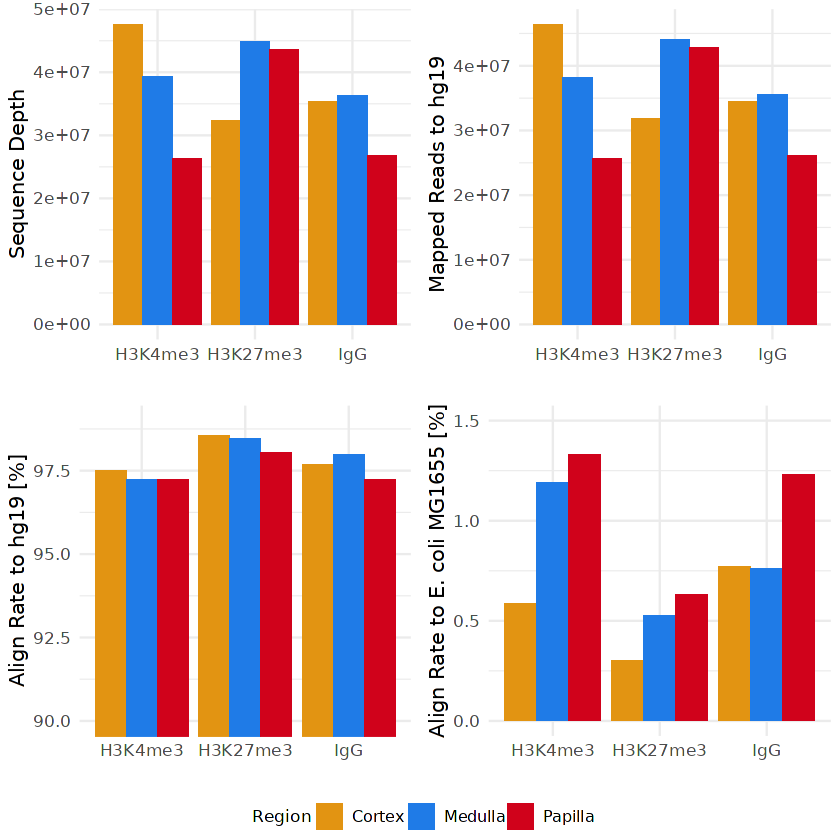

In [65]:
p = ggarrange(figA, figB, figC, figD, ncol = 2, nrow=2, common.legend = TRUE, legend="bottom")
p

ggsave(filename = file.path(outPath, "sequencing_depth.pdf"), p, width = 8, height = 6, units = "in", dpi = 300)
ggsave(filename = file.path(outPath, "sequencing_depth.png"), p, width = 8, height = 6, units = "in", dpi = 300)
